6334
(1334, 12)


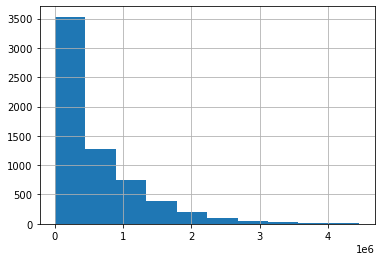

In [1]:
import pydicom
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pydicom
import glob


from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
#import gdcm
import cv2
import warnings
from fastai.vision.all import *
from fastai.medical.imaging import *
warnings.filterwarnings('ignore')
dataset_path = Path('/home/sangjun.park/siim-covid19-detection')
import vtk
# numba
import numba
from numba import jit
from vtk.util import numpy_support
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings
from torchvision.models.detection import backbone_utils
from torchvision.models.detection.backbone_utils import _validate_trainable_layers

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from pydicom import dcmread

from matplotlib import pyplot as plt
import random
paddingSize= 0
    


reader = vtk.vtkDICOMImageReader()


# Thanks https://www.kaggle.com/tanlikesmath/siim-covid-19-detection-a-simple-eda
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data


    
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()
    


def image_path(row):
    study_path = dataset_path/'train'/row.StudyInstanceUID
    for i in get_dicom_files(study_path):
        if row.id.split('_')[0] == i.stem: return i 
        


class Config:
    n_folds: int = 5
    seed: int = 2020
    num_classes: int = 2
    img_size: int = 256
    fold_num: int = 0
    device: str = 'cuda:0'



def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(Config.seed)

train_image_df = pd.read_csv('/home/sangjun.park/siim-covid19-detection/train_image_level.csv')


# Thanks https://www.kaggle.com/tanlikesmath/siim-covid-19-detection-a-simple-eda
train_image_df['class'] = train_image_df.label.apply(lambda x: x.split()[0])


train_image_df['x_min'] = train_image_df.label.apply(lambda x: float(x.split()[2]))
train_image_df['y_min'] = train_image_df.label.apply(lambda x: float(x.split()[3]))
train_image_df['x_max'] = train_image_df.label.apply(lambda x: float(x.split()[4]))
train_image_df['y_max'] = train_image_df.label.apply(lambda x: float(x.split()[5]))



def get_bbox_area(row):
    return (row['x_max']-row['x_min'])*(row['y_max']-row['y_min'])


train_image_df['bbox_area'] = train_image_df.apply(get_bbox_area, axis=1)

train_image_df['image_path'] = train_image_df.apply(image_path, axis=1)

train_image_df['bbox_area'].hist()

imgs = []
image_paths = train_image_df['image_path'].values
class_ids = train_image_df['class']

# map label_id to specify color
label2color = {class_id:[random.randint(0,255) for i in range(3)] for class_id in class_ids}
thickness = 3
scale = 5


image_ids = train_image_df['id'].unique()
valid_ids = image_ids[-5000:]# Tran and Validation Split 
train_ids = image_ids[:-5000]


valid_df = train_image_df[train_image_df['id'].isin(valid_ids)]
train_df = train_image_df[train_image_df['id'].isin(train_ids)]

train_df["class_id"] = [1]*len(train_df)
valid_df["class_id"] = [1]*len(valid_df)
print(len(train_image_df))
print(train_df.shape)
train_df.head()

class COVIDTrainDataLoader(Dataset): #Class to load Training Data
    
    def __init__(self, dataframe, transforms=None,stat = 'Train'):
        super().__init__()
        
        self.image_ids = dataframe["id"].unique()
        
        self.df = dataframe
        self.transforms = transforms
        self.stat = stat

        
    def __getitem__(self, index):
        if self.stat == 'Train':
            
            image_id = self.image_ids[index]
            
            records = self.df[(self.df['id'] == image_id)]
            records = records.reset_index(drop=True)
            image = dicom2array(self.df[(self.df['id'] == image_id)]['image_path'].values[0])#dcmread

            #image = ds.pixel_array
           
            '''if "PhotometricInterpretation" in dicom:
                if dicom.PhotometricInterpretation == "MONOCHROME1":
                    image = np.amax(image) - image'''

            intercept =  0.0
            slope =1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

            
            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if records.loc[0, "class_id"] == 0:
                records = records.loc[[0], :]

            boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
            boxes = torch.tensor(boxes, dtype = torch.float32)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
            labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

            # suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['id'] = torch.tensor([index])
            target['area'] = area
            target['iscrowd'] = iscrowd


            if self.transforms:
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                sample = self.transforms(**sample)
                image = sample['image']
                target['boxes'] = torch.tensor(sample['bboxes'])
                target['boxes'] = torch.as_tensor(target['boxes'], dtype = torch.float32)

            if target["boxes"].shape[0] == 0:
                # Albumentation cuts the target (class 14, 1x1px in the corner)
                target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
                target['boxes'] = torch.as_tensor(target['boxes'], dtype = torch.float32)
                target["area"] = torch.tensor([1.0], dtype=torch.float32)
                target["labels"] = torch.tensor([0], dtype=torch.int64)
            
            return image, target, image_ids
        
        else:
                   
            image_id = self.image_ids[index]
            records = self.df[(self.df['id'] == image_id)]
            records = records.reset_index(drop=True)

            image = dicom2array(self.df[(self.df['id'] == image_id)]['image_path'].values[0])#dcmread

            #image = ds.pixel_array

            intercept =  0.0
            slope = 1.0

            if slope != 1:
                image = slope * image.astype(np.float32)
                image = image.astype(np.int16)

            image += np.int16(intercept)


            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if self.transforms:
                sample = {
                    'image': image,
                }
                sample = self.transforms(**sample)
                image = sample['image']

            return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

# Albumentations
def get_train_transform():
    return A.Compose([
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ])

# Thanks https://www.kaggle.com/pestipeti/competition-metric-details-script


@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy


    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1


    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.
       The mean average precision at different intersection over union (IoU) thresholds.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

iou_thresholds = [0.5]


class EvalMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.image_precision = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, gt_boxes, pred_boxes, n=1):       
        """ pred_boxes : need to be sorted."""
        
        self.image_precision = calculate_image_precision(pred_boxes,
                                                         gt_boxes,
                                                         thresholds=iou_thresholds,
                                                         form='pascal_voc')
        self.count += n
        self.sum += self.image_precision * n
        self.avg = self.sum / self.count




In [2]:
class FastRCNNPredictornew(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictornew, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)
        self.cls_list = []

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        self.cls_list.append(scores)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

    def print_cls_score(self):
        print(self.cls_list)

In [ ]:

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictornew(in_features, 2)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = COVIDTrainDataLoader(train_df, get_train_transform())
valid_dataset = COVIDTrainDataLoader(valid_df, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
# Create train and validate data loader
train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,   
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs =  10 #low epoch to save GPU time

loss_hist = Averager()
itr = 1
lossHistoryiter = []
lossHistoryepoch = []

import time
start = time.time()

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        



        loss_dict = model(images, targets) 

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_hist.send(loss_value)
        lossHistoryiter.append(loss_value)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    lossHistoryepoch.append(loss_hist.value)
    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time taken to Train the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


Iteration #50 loss: 0.27529218792915344
Iteration #100 loss: 0.2427007555961609
Iteration #150 loss: 0.22743350267410278
Iteration #200 loss: 0.25621405243873596
Iteration #250 loss: 0.29965585470199585
Iteration #300 loss: 0.12674552202224731
Iteration #350 loss: 0.1669808179140091
Iteration #400 loss: 0.2573414444923401
Iteration #450 loss: 0.29841452836990356
Iteration #500 loss: 0.27481332421302795
Iteration #550 loss: 0.19184733927249908
Iteration #600 loss: 0.2886522114276886
Iteration #650 loss: 0.2192782312631607
Epoch #0 loss: 0.24965485997464523
Iteration #700 loss: 0.20118990540504456
Iteration #750 loss: 0.13909512758255005
Iteration #800 loss: 0.19838851690292358
Iteration #850 loss: 0.24703572690486908
Iteration #900 loss: 0.22190500795841217
Iteration #950 loss: 0.30124539136886597
Iteration #1000 loss: 0.29644155502319336
Iteration #1050 loss: 0.19309909641742706
Iteration #1100 loss: 0.17005914449691772
Iteration #1150 loss: 0.18867462873458862
Iteration #1200 loss: 0.

In [6]:
!nvidia-smi

Wed Sep  1 19:50:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Quadro R...  Off  | 00000000:00:06.0 Off |                    0 |
| N/A   38C    P0    65W / 250W |  22693MiB / 22698MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:


class COVIDValidDataLoader(Dataset): #Class to load Training Data
    
    def __init__(self, dataframe, transforms=None,stat = 'Train'):
        super().__init__()
        
        self.image_ids = dataframe["id"].unique()
        
        self.df = dataframe
        self.transforms = transforms
        self.stat = stat
        
    def __getitem__(self, index):
        if self.stat == 'Train':
            
            image_id = self.image_ids[index]
            
            records = self.df[(self.df['id'] == image_id)]
            records = records.reset_index(drop=True)
            image = dicom2array(self.df[(self.df['id'] == image_id)]['image_path'].values[0])#dcmread

            #image = ds.pixel_array
           
            '''if "PhotometricInterpretation" in dicom:
                if dicom.PhotometricInterpretation == "MONOCHROME1":
                    image = np.amax(image) - image'''

            intercept =  0.0
            slope =1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

            
            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if records.loc[0, "class_id"] == 0:
                records = records.loc[[0], :]

            boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
            labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

            # suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            #target['id'] = torch.tensor([index])
            target['id'] = image_id
            target['area'] = area
            target['iscrowd'] = iscrowd

            if self.transforms:
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                sample = self.transforms(**sample)
                image = sample['image']

                target['boxes'] = torch.tensor(sample['bboxes'])

            if target["boxes"].shape[0] == 0:
                # Albumentation cuts the target (class 14, 1x1px in the corner)
                target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
                target["area"] = torch.tensor([1.0], dtype=torch.float32)
                target["labels"] = torch.tensor([0], dtype=torch.int64)
            
            return image, target, image_id
        
        else:
                   
            image_id = self.image_ids[index]
            records = self.df[(self.df['id'] == image_id)]
            records = records.reset_index(drop=True)

            image = dicom2array(self.df[(self.df['id'] == image_id)]['image_path'].values[0])#dcmread

            #image = ds.pixel_array

            intercept =  0.0
            slope = 1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if self.transforms:
                sample = {
                    'image': image,
                }
                sample = self.transforms(**sample)
                image = sample['image']

            return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]



In [8]:
valid_dataset = COVIDValidDataLoader(valid_df, get_valid_transform())

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [9]:
def format_prediction_string(image_id,labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
#         pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
#             j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))
          pred_strings.append([image_id,j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]])

    return pred_strings

In [10]:
model.eval()
detection_threshold = 0.5
results = []
answers = []

with torch.no_grad():
    # pred_boxes (list) : [[train_idx, class_pred, prob_score, x1, y1, x2, y2], ... ]    
    for images, targets, image_ids in valid_data_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
        
        outputs = model(images)
        
        for i,target in enumerate(targets):
            answer = [target['id'],target['labels'][0].item(),1, 
                      target['boxes'][0][0].item(), target['boxes'][0][1].item(), target['boxes'][0][2].item(), target['boxes'][0][3].item()]
            answers.append(answer)
        for i, image in enumerate(images):
            
            image_id = image_ids[i]

            result = {
                'image_id': image_id,
                'PredictionString': '14 1.0 0 0 1 1'
            }

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            if len(boxes) > 0:

#                 labels = labels - 1
#                 labels[labels == -1] = 1

                selected = scores >= detection_threshold

                boxes = boxes[selected].astype(np.int32)
                scores = scores[selected]
                labels = labels[selected]

                if len(boxes) > 0:
#                     result = {
#                         'image_id': image_id,
#                         'PredictionString': format_prediction_string(image_id,labels, boxes, scores)
#                     }
                    
                    result = format_prediction_string(image_id,labels,boxes,scores)

            results.extend(result)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 22.17 GiB total capacity; 2.39 GiB already allocated; 5.81 MiB free; 8.74 GiB reserved in total by PyTorch)

In [ ]:
print(result)

In [ ]:

from collections import Counter

def iou_calc(bb1, bb2):
    ## 오른쪽 좌표가 왼쪽 좌표보다 커야 하고, 위 좌표가 아래 좌표보다 커야 함 그렇지 않을 경우 asserterror
#     assert bb1['x1'] < bb1['x2']
#     assert bb1['y1'] < bb1['y2']
#     assert bb2['x1'] < bb2['x2']
#     assert bb2['y1'] < bb2['y2']

    ## 두개의 bounding box가 겹치는 영역의 좌표
    x_left = max(bb1[0], bb2[0])
    x_right = min(bb1[2], bb2[2])
    y_bottom = max(bb1[1], bb2[1])
    y_top = min(bb1[3], bb2[3])

    if x_right < x_left or y_top < y_bottom: return 0

    intersection_area = (x_right - x_left) * (y_top - y_bottom)

    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    iou = intersection_area / (bb1_area + bb2_area - intersection_area)

    assert iou <= 1
    assert iou >= 0
    return iou

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format='corners', num_classes=2):
    # pred_boxes (list) : [[train_idx, class_pred, prob_score, x1, y1, x2, y2], ... ]
    average_precisions = []
    epsilon = 1e-6

    # 각각의 클래스에 대한 AP를 구합니다.
    for c in range(num_classes):
        detections = []
        ground_truths = []

        # 모델이 c를 검출한 bounding box를 detections에 추가합니다.
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        # 실제 c 인 bounding box를 ground_truths에 추가합니다.
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # amount_bboxes에 class에 대한 bounding box 개수를 저장합니다.
        # 예를 들어, img 0은 3개의 bboxes를 갖고 있고 img 1은 5개의 bboxes를 갖고 있으면
        # amount_bboexs = {0:3, 1:5} 가 됩니다.
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # class에 대한 bounding box 개수 만큼 0을 추가합니다.
        # amount_boxes = {0:torch.tensor([0,0,0]), 1:torch.tensor([0,0,0,0,0])}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # detections를 정확도 높은 순으로 정렬합니다.
        detections.sort(key=lambda x: x[2], reverse=True)

        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

		# TP와 FP를 구합니다.
        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]]
            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = iou_calc(torch.tensor(detection[3:]),
                                              torch.tensor(gt[3:]),)

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            else:
                FP[detection_idx] = 1
        
        # cumsum은 누적합을 의미합니다.
        # [1, 1, 0, 1, 0] -> [1, 2, 2, 3, 3]
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]),recalls))
        
        # torch.trapz(y,x) : x-y 그래프를 적분합니다.
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [ ]:
mean_average_precision(results,answers)

In [ ]:
with torch.no_grad():
    # pred_boxes (list) : [[train_idx, class_pred, prob_score, x1, y1, x2, y2], ... ]    
    for images, targets, image_ids in valid_data_loader:

#이런거 있는 코드 돌리시면 valid 데이터셋의 예측 결과가 정리된 results가 만들어져요. 일단 results 있으면 시각화 코드는 돌릴 수 있습니다. 그치만 순서 헷갈리니까 mean_average_precision(results,answers) 코드 다음에 붙여서 쓰시는것을 추천 드립니다..

#4개 클래스 구분할 경우 시각화:
#1) 필요한 데이터와 함수 정의
results_df=pd.DataFrame(results)
results_df.columns=['image_id', 'pred_type', 'prob_score', 'x_min', 'y_min', 'x_max', 'y_max']

imgs = []
valid_image_ids = results_df['image_id'].values
type_ids = train_image_df['type_id']

# map label_id to specify color
#label2color = {type_id:[random.randint(0,255) for i in range(3)] for type_id in type_ids}
label2color = {0: [0, 0, 0],
               1: [255, 0, 0],
               2: [0, 255, 0],
               3: [0, 0, 255]}
thickness = 3
scale = 5

def label_to_name(label):
    if label == 0 : name ="Negative for Pneumonia"
    elif label == 1 : name = "Typical Appearance"
    elif label == 2: name = "Indeterminate Appearance"
    elif label == 3: name = "Atypical Appearance"
    return name


#2) ground truth 박스 그리기
sample_paths=[]
for i in range(8):
    id = random.choice(valid_image_paths)
    image_path = valid_df.loc[valid_df['id']==id, ['image_path']].values[0][0]
    img = dicom2array(str(image_path))
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    label = valid_df.loc[valid_df['image_path'] == image_path, ['type_id']].values[0][0]
    
    sample_paths.append(image_path)
    print(image_path)
    
    boxes=[]
    num = valid_df.loc[valid_df['id']==id, ['image_path']].count()[0]
    for j in range(num):
        box = valid_df.loc[valid_df['image_path'] == image_path, ['x_min', 'y_min', 'x_max', 'y_max']].values[j]/scale
        boxes.append(box)
        
        color = label2color[label]
        img = cv2.rectangle(
            img,
            (int(boxes[j][0]), int(boxes[j][1])),
            (int(boxes[j][2]), int(boxes[j][3])),
            color, thickness)
        img = cv2.putText(img, label_to_name(label), (int(boxes[j][0]), int(boxes[j][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3, cv2.LINE_AA)

    img = cv2.resize(img, (500,500))
    imgs.append(img)
    print(boxes)
    
    plot_img(img, cmap=None)


    #3) predict 박스 그리기
for i in range(8):
    image_path = sample_paths[i]
    image_id = sample_ids[i]
    print(sample_paths[i])
    
    img = dicom2array(str(image_path))
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    label = results_df.loc[results_df['image_id'] == image_id, ['pred_type']].values[0][0]
    
    boxes=[]
    num = results_df.loc[results_df['image_id'] == image_id].count()[0]
    for j in range(num):
        box = results_df.loc[results_df['image_id'] == image_id, ['x_min', 'y_min', 'x_max', 'y_max']].values[j]/scale
        boxes.append(box)
        
        color = label2color[label]
        img = cv2.rectangle(
            img,
            (int(boxes[j][0]), int(boxes[j][1])),
            (int(boxes[j][2]), int(boxes[j][3])),
            color, thickness)
        img = cv2.putText(img, label_to_name(label), (int(boxes[j][0]), int(boxes[j][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3, cv2.LINE_AA)
    
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    print(boxes)
    
    plot_img(img, cmap=None)    